<h1>Solving differential equations in Python numerically for forward propagation of times</h1>

<h3>Idea: A general ordinary differential equation has the shape<br><br>
    $u'(t) = f(u(t),t)$<br><br>
    For example, the exponential decay equation is derived from the solution of the differential equation<br><br>
    $N'(t) = -\lambda N(t) \equiv f(u(t),t)$<br><br>
    In the so-called Euler method, the differential equation is solved by starting from the initial (known) values, and propagating the value for discrete time points with small intervals, $t_0, t_1, t_2, \dots, t_n$.<br>
    An ordinary differential equation at time $t_n$ is therefore written as<br><br>
    $u'(t_n) = f(u(t_n),t_n)$,<br><br>
    which is also possible to evaluate by forward finite difference,<br><br>
    $u'(t_n) = \frac{u(t_{n+1} - u(t_n)}{\Delta t}$,<br><br>
    so that the full equation becomes<br><br>
    $\frac{u(t_{n+1} - u(t_n)}{\Delta t} = f(u(t_n),t_n)$.<br><br>
    Solving the equation for $u(t_{n+1})$ gives<br><br>
    $u(t_{n+1}) = u(t_n) + \Delta t f(u(t_n),t_n)$,<br><br>
    or in a shorter version,<br><br>
    $u_{n+1} = u_n + \Delta t f(u_n,t_n)$.
    </h3>

<h3>For the radiactive decay example from above, we thus need to have an initial value for the number of particles, $N_0$, and have to know the decay constant $\lambda$. Then we can just calculate the solution with a for loop:</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('thomas')

Text(0, 0.5, 'N(t)')

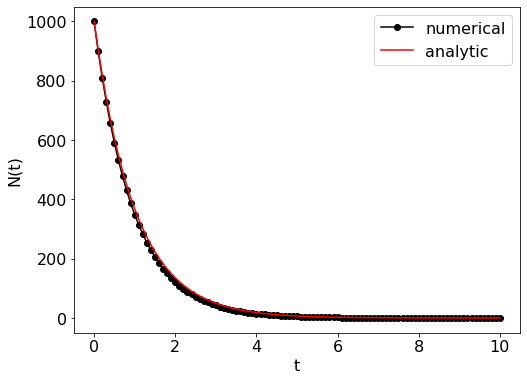

In [2]:
# time step
dt = 0.1

# initial value for N0 (1000); (I keep it at U0 to be consistent with the rest of the notebook)
U0 = 1000
# decay constant
lamb = 1 

# total time to calculate differential equation
T = 10

# number of total evaluations
num = int(T/dt)

# initialising arrays of time (t) and solution (u) for the number of evaluations
t = np.zeros(num+1)
u = np.zeros(num+1)

# initial values
t[0] = 0
u[0] = U0

# looping over the points in time
for n in range(num):
    t[n+1] = t[n] + dt     # updating time
    u[n+1] = u[n] + dt*(-lamb*u[n]) #

# exact solution:
N = U0*np.exp(-lamb*t)
    
# plotting the result
plt.plot(t,u,'o-',label='numerical')
plt.plot(t,N,'r-',label='analytic')
plt.legend()
plt.xlabel('t')
plt.ylabel('N(t)')
# also check the logarithmic scale
#plt.xscale('log')
#plt.yscale('log')

<h3>Instead of writing this in another cell every time, we make a function out of that:</h3>

In [3]:
def ForwardEuler_v0(f, U0, T, num, *args):
    """Solve u’=f(u,t), u(0)=U0, with num steps until t=T."""
    t = np.zeros(num+1)
    u = np.zeros(num+1) # u[n] is the solution at time t[n]
    u[0] = U0
    t[0] = 0
    dt = T/num
    for n in range(num):
        t[n+1] = t[n] + dt
        u[n+1] = u[n] + dt*f(u[n], t[n], *args) # now we use a function here that we define below
    return u, t

Text(0, 0.5, 'N(t)')

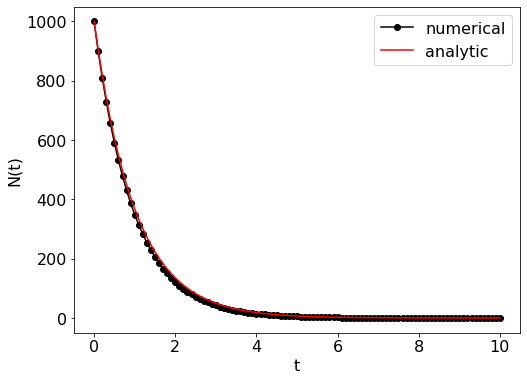

In [4]:
def f(u, t, lamb):
    return -lamb*u
U0 = 1000
T = 10
num = 100
u, t = ForwardEuler_v0(f, U0, T, num, lamb)

plt.plot(t,u,'o-',label='numerical')
plt.plot(t,N,'r-',label='analytic')
plt.legend()
plt.xlabel('t')
plt.ylabel('N(t)')

<h3>Now we make the same thing with a class that holds our function, initial conditions, and then solves the differential equation as before.<br>
But first, a quick and certainly not complete overview of classes:</h3>

In [5]:
# definition of the class (its name)
class particle:
    
    # every class has to have an init file where some things are defined
    # here we define the name of the particle, its mass, its charge, and some properties are
    # set automatically to 0, like the initial time, position, and velocity
    # the "self" is always referring to the object itself, so if we just define the init
    # we can access the name, mass, etc, by a dot to the variable:
    def __init__(self,name,mass,charge,t0=0,x0=0,v0=0):
        self.name = name
        self.x = x0
        self.v = v0
        self.mass = mass
        self.charge = charge
        self.t = t0

In [6]:
p1 = particle(name='electron',
              mass=511,
              charge=-1)

In [7]:
p1.t,p1.charge,p1.mass

(0, -1, 511)

<h3>Now, this is just the same as a python dictionary, which holds values in certain variables. In addition, we can also define attributes, either as functions of new variables. Let's define a function that updates the position of the particle as if it would "fall", i.e. for a given time step $\Delta t$, we update the time as $t \rightarrow t+\Delta t$, the position as $x \rightarrow x + v \cdot \Delta t$ and the velocity as $v \rightarrow v + g \cdot \Delta t$. Almost like a differential equation, only that we already know the solution:</h3>

In [8]:
class particle:
    
    def __init__(self,name,mass,charge,t0=0,x0=0,v0=0):
        self.name = name
        self.x = x0
        self.v = v0
        self.mass = mass
        self.charge = charge
        self.t = t0
    
    # this is a function which is called with the particle
    # it uses a time step dt, and an acceleration g that are given to the function
    # as described above, we update the values of t, x, and v here
    def propagate_fall(self,dt,g):
        self.t = self.t + dt
        self.x = self.x + self.v*dt
        self.v = self.v + g*dt

Text(0, 0.5, 'x')

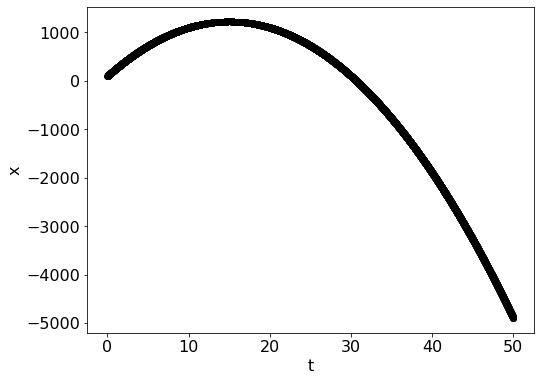

In [9]:
p1 = particle(name='electron',
              x0=100, # including the initial poisition
              v0=150,  # and velocity here
              mass=511,
              charge=-1)

# time step
dt = 0.01
# number of time steps for updates
N = 5000
# initialsation of x and v array with just zeros
x_arr = np.zeros(N)
v_arr = np.zeros(N)
# time array for plotting in the end
t_arr = np.linspace(0,dt*N,N)

# here we loop over the N=5000 time steps and propagate the particle 1000 times with a time step of dt = 0.01
for i in range(N):
    # propagate function
    p1.propagate_fall(dt,-10)
    # filling the empty arrays
    x_arr[i] = p1.x
    v_arr[i] = p1.v
    
# plotting the result
plt.plot(t_arr,x_arr,'o-')
plt.xlabel('t')
plt.ylabel('x')

<h3>You see that the particle is not stopping at $x=0$, so we can write another function that takes into account that a particle should actually bounce:</h3>

In [10]:
class particle:
    
    def __init__(self,name,mass,charge,t0=0,x0=0,v0=0):
        self.name = name
        self.x = x0
        self.v = v0
        self.mass = mass
        self.charge = charge
        self.t = t0
    
    def propagate_fall(self,dt,g):
        self.t = self.t + dt
        self.x = self.x + self.v*dt
        self.v = self.v + g*dt
    
    # here I add a function to overwrite the initial conditions, so that
    # we dont need to construct the particle object again and again
    def set_initial_conditions(self,x0,v0):
        self.x = x0
        self.v = v0

    # this function now distinguishes between the particle above x=0 or below, where it just switches
    # the sign of the velocity
    def propagate_bounce(self,dt,g):
        self.t = self.t + dt
        self.x = self.x + self.v*dt

        if self.x > 0:
            self.v = self.v + g*dt
        else:
            self.v = -self.v

Text(0, 0.5, 'x')

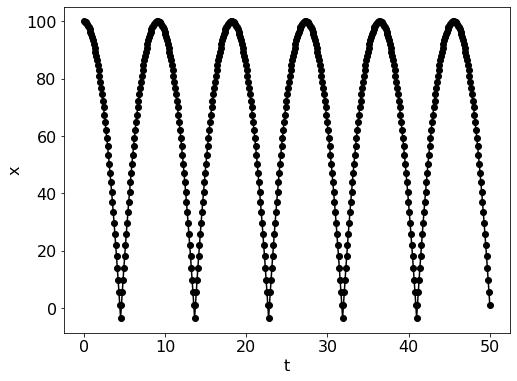

In [11]:
p1 = particle(name='electron',
              x0=100,
              v0=0,
              mass=511,
              charge=-1)

dt = 0.1
N = 500
x_arr = np.zeros(N)
v_arr = np.zeros(N)
t_arr = np.linspace(0,dt*N,N)


for i in range(N):
    p1.propagate_bounce(dt,-10)
    x_arr[i] = p1.x
    v_arr[i] = p1.v
    
# plotting the result
plt.plot(t_arr,x_arr,'o-')
plt.xlabel('t')
plt.ylabel('x')

<h3>Now you see that the particle is bouncing to the same height as before. To make it more 'realistic', we can add the coefficient of restitution (Stoßzahl) $e$, which we might also make dependent on the particle mass (which it might not be in reality), so that different particles bounce differently and 'lose energy' in the process of bouncing:</h3>

In [12]:
class particle:
    
    def __init__(self,name,mass,charge,t0=0,x0=0,v0=0):
        self.name = name
        self.x = x0
        self.v = v0
        self.mass = mass
        self.charge = charge
        self.t = t0
    
    def propagate_fall(self,dt,g):
        self.t = self.t + dt
        self.x = self.x + self.v*dt
        self.v = self.v + g*dt
    
    # here I add a function to overwrite the initial conditions, so that
    # we dont need to construct the particle object again and again
    def set_initial_conditions(self,x0,v0):
        self.x = x0
        self.v = v0

    def propagate_bounce(self,dt,g):
        self.t = self.t + dt
        self.x = self.x + self.v*dt

        if self.x > 0:
            self.v = self.v + g*dt
        else:
            self.v = -self.v
            
    # this function now distinguishes between the particle above x=0 or below, where it just switches
    # the sign of the velocity
    def propagate_bounce_real(self,dt,g):
        # this calculation should only be done once, but ok:
        self.e = 400/self.mass # arbitrary calculation here
        self.t = self.t + dt
        self.x = self.x + self.v*dt

        if self.x > 0:
            self.v = self.v + g*dt
        else:
            self.v = -self.v*self.e

Text(0, 0.5, 'x')

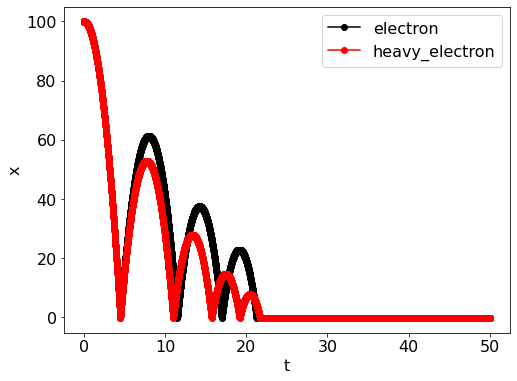

In [13]:
p1 = particle(name='electron',
              x0=100,
              v0=0,
              mass=511.,
              charge=-1)

# now a second particle that we call heavy electron because it just is a little heavier
p2 = particle(name='heavy_electron',
              x0=100,
              v0=0,
              mass=550.,
              charge=-1)

dt = 0.01
N = 5000
# now we have two particles, so we need to duplicate the entries here vor p1 and p2
# p1
x1_arr = np.zeros(N)
v1_arr = np.zeros(N)
# p2
x2_arr = np.zeros(N)
v2_arr = np.zeros(N)
# the time is the same for both
t_arr = np.linspace(0,dt*N,N)

# one for loop for both particles
for i in range(N):
    p1.propagate_bounce_real(dt,-10)
    p2.propagate_bounce_real(dt,-10)
    x1_arr[i] = p1.x
    v1_arr[i] = p1.v
    x2_arr[i] = p2.x
    v2_arr[i] = p2.v


    
# plotting the result
plt.plot(t_arr,x1_arr,'ko-',label=p1.name)
plt.plot(t_arr,x2_arr,'ro-',label=p2.name)
plt.legend()
plt.xlabel('t')
plt.ylabel('x')

<h3>Because we defined $e = 400/m$, a value near $e=1$ will result in a slowly declining bounce (electron) and an $e$-value much smaller than 1 will result in a heavy suppression (heavy electron).</h3>

<h3>How that you got a glimpse of classes, we want to write our Euler solver as a class:</h3>

In [14]:
class ForwardEuler_v1:
    
    # here the class takes the function (the differential equation)
    def __init__(self, f):
        self.f = f
        
    # seeting the initial conditions of the 1D problem
    def set_initial_condition(self,U0):
        self.U0 = float(U0)
        
    # iterative solution with forward differences in time
    def solve(self, time_points):
        """Compute solution for array of time points"""
        # time points
        self.t = np.asarray(time_points)
        # number of times
        N = len(self.t)
        # function solutions at time t
        self.u = np.zeros(N)
        # initial value
        self.u[0] = self.U0
        # loop over time
        for n in range(N-1):
            self.n = n                   # number of iteration
            self.u[n+1] = self.advance() # future value will be calculated by the advance() function
        return self.u, self.t
        
    def advance(self):
        """Advance the solution one time step."""
        # create local variables to get rid of "self." in the numerical formula
        u, f, n, t = self.u, self.f, self.n, self.t
        # dt is not necessarily constant so we calculate it here from the current and previous calue
        dt = t[n+1]-t[n]
        # update the value
        unew = u[n] + dt*f(u[n], t[n])
        # return the value to the be written into self.u[n+1]
        return unew

<h3>In this way, we can give arbitrary differential equations to the ForwardEuler_v1 class. We define our differential equation also as class, so for example for the Exponential Decay:</h3>

In [15]:
class Exponential_Decay:
    def __init__(self, lamb, U0):
        self.lamb, self.U0 = lamb, U0
    def __call__(self, u, t): # f(u,t)
        return -self.lamb*u # so, this reads now f(u(t),t) == u'(t) = -lambda * u(t)

Text(0, 0.5, 'N(t)')

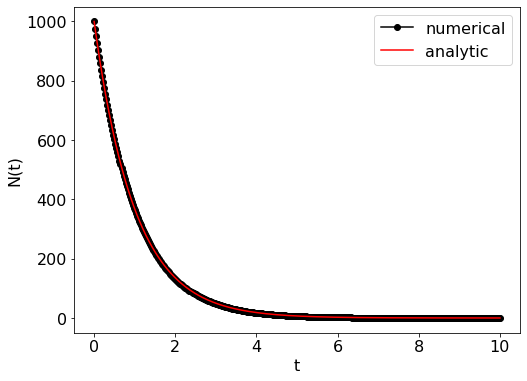

In [16]:
# setting up the problem
problem = Exponential_Decay(lamb=1,
                            U0=1000)

# defining the times
time = np.linspace(0,10,401)

# choosing the method (or solver, see below)
method = ForwardEuler_v1(problem)

# seeting the initial conditions if not set before
method.set_initial_condition(problem.U0)

# calculating the solution:
u, t = method.solve(time)

# plotting the result
plt.plot(time,u,'o-',label='numerical')
plt.plot(time,1000*np.exp(-1*time),'r-',label='analytic')
plt.legend()
plt.xlabel('t')
plt.ylabel('N(t)')

<h3>The pythonic assignment<br>
    u, t = method.solve(time)<br>
    is just a way to assigned two variables at the same time since .solve() results two arrays.<br>
    The same information in the variables u and t is also saved internally in the object 'method' itself, so that you could also do the plot in this way:</h3>

Text(0, 0.5, 'N(t)')

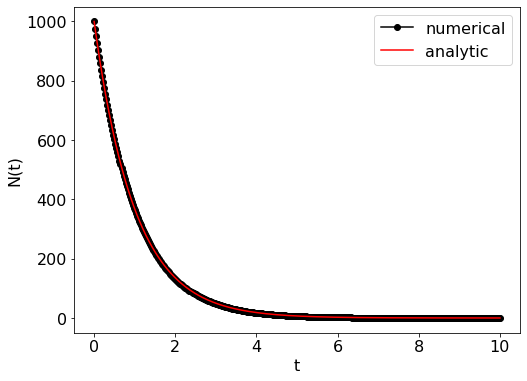

In [17]:
# plotting the result
plt.plot(method.t,method.u,'o-',label='numerical')
plt.plot(time,1000*np.exp(-1*time),'r-',label='analytic')
plt.legend()
plt.xlabel('t')
plt.ylabel('N(t)')

<h3>Since the accuracy or this forward difference in time is limited, there are many other solvers that take into account the times between the time edges, for example, or two points inbetween. In addition, there is also the possibility to have more than one ordinary differential equation, such as with a second derivative, or just linked differential equations. For this one can define the same methods, but with $u$ as a vector instead of a single value.<br>
    In the following I define a super class called ODESolver, which is just the same as before, but also works for more dimensions. The .advance() function can then be chosen to either be the Euler method again, or something more sophisticated (see below).</h3>

In [18]:
class ODESolver:
    
    def __init__(self, f):
        # wrap function f in a new function that always
        # converts list/tuple to array (or let array be array)
        self.f = lambda u, t: np.asarray(f(u, t), float)
        
    def set_initial_condition(self, U0):
        if isinstance(U0, (float,int)): # scalar differential equation
            self.neq = 1                # no of equations
            U0 = float(U0)              # initial value
        else:                           # system of ODEs
            U0 = np.asarray(U0)         # initial valueS
            self.neq = U0.size          # no of equations
        self.U0 = U0                    # setting the initial values
    
    # same as before just with more dimensions if needed
    def solve(self, time_points):
        self.t = np.asarray(time_points)
        N = len(self.t)
        if self.neq == 1: # scalar ODEs
            self.u = np.zeros(N)
        else: # systems of ODEs
            self.u = np.zeros((N,self.neq))
            # assume that self.t[0] corresponds to self.U0
        self.u[0] = self.U0
        # loop over time
        for n in range(N-1):
            self.n = n
            self.u[n+1] = self.advance()
        return self.u, self.t

<h3>After defining the superclass, we need to define the .advance() function in child classes. This is done in the following way, by naming a new class, and giving it the parent class as argument:</h3>

In [19]:
class ForwardEuler(ODESolver):
    # same as before
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = t[n+1] - t[n]
        unew = u[n] + dt*f(u[n], t[n])
        return unew

In [20]:
# This method uses also the time point between n+1 and n
class ExplicitMidpoint(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = t[n+1] - t[n]
        dt2 = dt/2.0
        k1 = f(u[n], t)
        k2 = f(u[n] + dt2*k1, t[n] + dt2)
        unew = u[n] + dt*k2
        return unew

In [21]:
# This method uses two points inbetween n+1 and n
class RungeKutta4(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = t[n+1] - t[n]
        dt2 = dt/2.0
        k1 = f(u[n], t)
        k2 = f(u[n] + dt2*k1, t[n] + dt2)
        k3 = f(u[n] + dt2*k2, t[n] + dt2)
        k4 = f(u[n] + dt*k3, t[n] + dt)
        unew = u[n] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return unew

<h3>Now we can again define our differential equation as class, or as function. I define it here as function again because it might be easier to read for this final example:<br><br>
    Suppose we want to calculate the trajectory of throwing a ball without resistance. We have the equation of motion:<br><br>
    $m \vec{r}''(t) = -m g \hat{e}_z$<br><br>
    Now, this is an ordinary differential equation of second order, which does not work in the same way as with only the first derivatives like above. We can, however, define a set of six linked differential equations of first order by inventing the variable $\vec{v}(t) \equiv \vec{r}'(t)$, which, as you know, is just the velocity.<br>
    Writing out the differential equations now gives:<br><br>
    $x''(t) = 0 = v_x'(t) \leftrightarrow v_x'(t) = 0$<br>
    $y''(t) = 0 = v_y'(t) \leftrightarrow v_y'(t) = 0$<br>
    $z''(t) = -g = v_z'(t) \leftrightarrow v_z'(t) = -g$<br>
    $x'(t) = v_x(t)$<br>
    $y'(t) = v_y(t)$<br>
    $z'(t) = v_z(t)$<br><br>
    The solution for the two y dimensions is trivial (0), but I leave it in because it might be important for the particle in the magnetic field case, for example. Now we have our six equations, so that we can write:<br><br>
    $f(\vec{u}(t),t) \equiv (v_x'(t),v_y'(t),v_z'(t),x'(t),y'(t),z'(t))^T = (0,0,-g,v_x(t),v_y(t),v_z(t))^T$.<br><br>
    In python, we just put this formally in:</h3>
    

In [22]:
# function from above
def f(u, t):
    vx, vy, vz, x, y, z = u # derivatives
    g = 9.81                # graviational constant on Earth
    return [0, 0, -g, vx, vy, vz]

Text(0, 0.5, 'z')

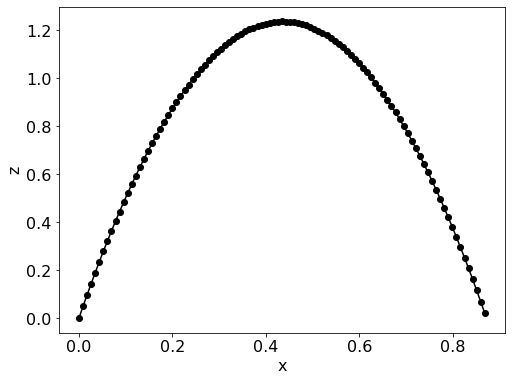

In [23]:
# ALL of the six differential equations need an initial value
# initial values for position:
x0, y0, z0 = 0, 0, 0

# initial values for velocity:
# magnitude of velocity vector
v0 = 5
# angle in the xz plane:
theta = 80 # deg
# converting theta from deg to rad
theta = np.deg2rad(theta)

# then calculating the initial velocity vector:
vx0 = v0*np.cos(theta)
vy0 = 0
vz0 = v0*np.sin(theta)

# initial value vector:
U0 = [vx0, vy0, vz0, x0, y0, z0]

# then setting up the solver (should work with all possibility from above, not only ForwardEuler)
#solver = ForwardEuler(f)
solver = ExplicitMidpoint(f)
#solver = RungeKutta4(f)

# setting the initial conditions
solver.set_initial_condition(U0)

# which times to calculate the thing for
time_points = np.linspace(0, 1.0, 101)

# solve the problem
u, t = solver.solve(time_points)

# plotting the result:
# u is an array of [vx,vy,vz,x,y,z] arrays,
# so to plot x and z we need the index 3 (x) and 5 (y) of u:
x = u[:,3]
z = u[:,5]

plt.plot(x, z, 'o-')
plt.xlabel('x')
plt.ylabel('z')

<h3>Plotting the coordinates as a function of time</h3>

Text(0, 0.5, 'coordinate')

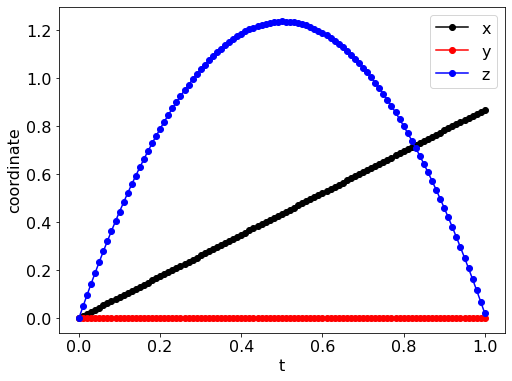

In [24]:
plt.plot(solver.t,solver.u[:,3],'ko-',label='x')
plt.plot(solver.t,solver.u[:,4],'ro-',label='y')
plt.plot(solver.t,solver.u[:,5],'bo-',label='z')
plt.legend()
plt.xlabel('t')
plt.ylabel('coordinate')

<h3>Plotting the velocities as a function of time</h3>

Text(0, 0.5, 'velocity coordinate')

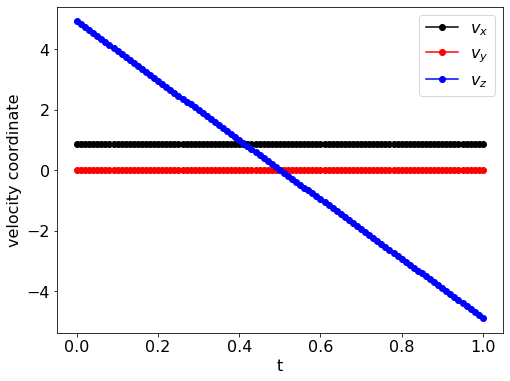

In [25]:
plt.plot(solver.t,solver.u[:,0],'ko-',label=r'$v_x$')
plt.plot(solver.t,solver.u[:,1],'ro-',label=r'$v_y$')
plt.plot(solver.t,solver.u[:,2],'bo-',label=r'$v_z$')
plt.legend()
plt.xlabel('t')
plt.ylabel('velocity coordinate')